# 超球面の体積(volume of unit ball)をMonte Carloで求める

## 単純Monte Carloの場合
d次元の単位超球面(unit ball)の体積は、Lemma 2.6 によると、
$$
V(d) = \frac{2 \pi^{\frac{d}{2}}}{d \Gamma(\frac{d}{2})}
$$

すべての次元の値が正(positive)の領域に限定すると、$\frac{1}{2^d}$倍になるから
$$
V_{+}(d) = \frac{\pi^{\frac{d}{2}}}{d \cdot 2^{d-1} \Gamma(\frac{d}{2})}
$$

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

%matplotlib inline
plt.rcParams['font.size'] = 14

In [10]:
# d次元の体積(すべての次元がpositiveとなる領域)
def volume_of_positive_unit_ball(d):
    return np.pi**(d/2) / (d * 2**(d-1) * scipy.special.gamma(d/2))

In [14]:
d_max = 20
d_vec = np.arange(d_max) + 1
volumes = volume_of_positive_unit_ball(d_vec)

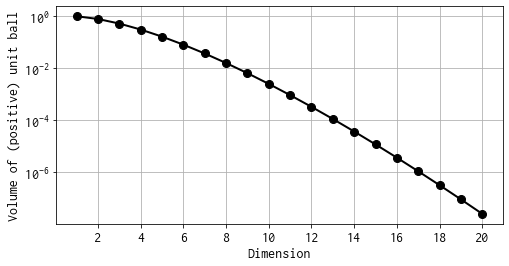

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_vec, volumes, 'o-', c='k', markersize=8, linewidth=2)
ax.set_xlabel('Dimension')
ax.set_ylabel('Volume of (positive) unit ball')
ax.set_yscale('log')
ax.set_xticks(range(2, 21, 2))
ax.grid(which='major')

In [28]:
def unit_sphere_simple_mc(d, n_sample=100000):
    real_volume = volume_of_positive_unit_ball(d)
    samples = np.random.uniform(size=(n_sample, d))

    flags_in_sphare = (samples ** 2).sum(axis=1) <= 1
    area_estimated = np.cumsum(flags_in_sphare) / (np.arange(n_sample) + 1)
    ratio_vs_real_volume = area_estimated / real_volume
    return ratio_vs_real_volume

In [300]:
d_max, n_sample = 20, 100000

results = np.zeros((n_sample, d_max))
for d in np.arange(d_max) + 1:
    results[:, d-1] = unit_sphere_simple_mc(d, n_sample=n_sample)

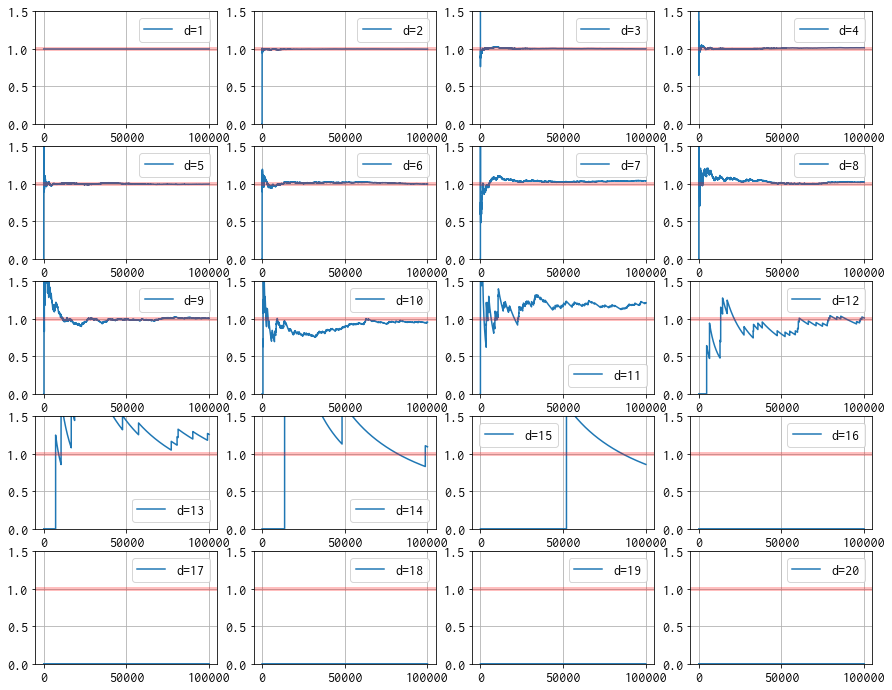

In [301]:
fig, axes = plt.subplots(5, 4, figsize=(15, 12))

x = np.arange(n_sample) + 1

for idx, ax in enumerate(axes.flatten()[:d_max]):
    d = idx + 1
    ax.plot(x, results[:, idx], '-', label=f'd={d}')
    ax.axhline(1.0, color='r', linewidth=4, alpha=0.25)
    ax.set_ylim([0, 1.5])
    ax.grid(which='major')
    ax.legend()

---
## Random Walk による体積の推定
- テキストとは違って、徐々に大きくなる正方形(rectangle) による単位球の体積(volume of unit sphere)の推定を実施する

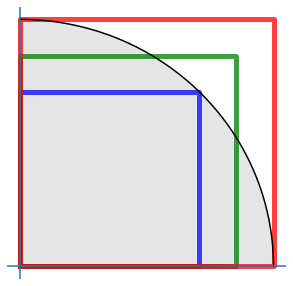

In [73]:
fig, ax = plt.subplots(figsize=[5, 5])

ax.set_axis_off()
theta = np.linspace(0, np.pi/2, 1000)
L = 1/np.sqrt(2)
M = (1 + L) / 2
ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], '-', c='b', linewidth=5, alpha=0.75)
ax.plot([0, M, M, 0, 0], [0, 0, M, M, 0], '-', c='g', linewidth=5, alpha=0.75)
ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], '-', c='r', linewidth=5, alpha=0.75)
ax.plot(np.sin(theta), np.cos(theta), '-', c='k')
ax.fill_between(np.sin(theta), np.cos(theta), 0, facecolor='k', alpha=0.1)
ax.axhline(0)
ax.axvline(0)

- すべての次元が正の単位球の体積を求めるために、次の手順を考える。
- この単位球に内接する最大の立方体(cube) (図の<font color='blue'>**緑**</font>)から徐々にサイズを大きくして、  
  この単位球に外接する最小の立方体(図の<font color='red'>**赤**</font>)まで大きくする
- 最小のcubeの1辺は $l = \frac{1}{\sqrt{d}}$
- 次に大きな cube は $1 + \frac{1}{d}$ 倍となるようにとる

In [228]:
np.ceil?

In [231]:
def calc_k(d):
    return np.ceil(.5 * np.log(d) / np.log(1 + 1/d)).astype(int)

In [232]:
calc_k(np.arange(1,21))

array([ 0,  1,  2,  4,  5,  6,  8,  9, 11, 13, 14, 16, 18, 20, 21, 23, 25,
       27, 29, 31])

In [79]:
np.random.choice(10)

7

In [81]:
np.trunc?

In [361]:
def random_walk_sampling(d, L_upper, L_lower, eps=0.025, n_sample=1000):
    start_pos = int(1 / np.sqrt(d) * 0.5 / eps) * eps

    vec = np.asarray([start_pos,] * d)
    prev = vec.copy()

    results = np.zeros(n_sample)
    
    for idx in range(n_sample):
        next_d = np.random.choice(d)
        vec[next_d] += eps if np.random.uniform() < .5 else -eps
        if np.any(vec < 0) or np.any(L_upper <= vec) or 1 < vec.dot(vec):
            vec[:] = prev
        
        if np.all(vec <= L_lower):
            results[idx] += 1
        
        prev[:] = vec
    
    return (np.arange(n_sample) + 1) / np.cumsum(results)

In [396]:
d = 15
L_min = 1 / np.sqrt(d)
k_max = calc_k(d)
Ls = [L_min * (1 + 1/d) ** k for k in np.arange(k_max + 1)]
V_min = L_min ** d

In [397]:
k_max

21

In [398]:
ratios = []
rejection_rates = []

for k in np.arange(1, k_max + 1):
    print(f'k={k}')
    ratio = random_walk_sampling(d, Ls[k], Ls[k-1], eps=0.02, n_sample=50000)
    ratios.append(ratio)

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21


In [399]:
V = np.vstack(ratios).prod(axis=0) * V_min

In [400]:
V_real = volume_of_positive_unit_ball(d)

In [401]:
V / V_real

array([1.29818182e-04, 1.29818182e-04, 1.29818182e-04, ...,
       1.78941228e+00, 1.78938911e+00, 1.78936596e+00])

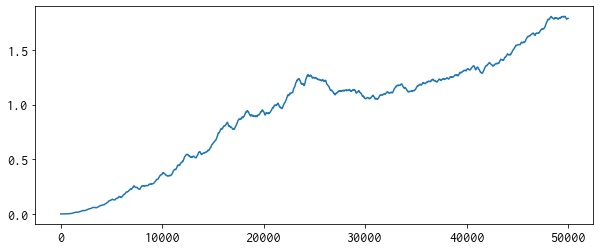

In [402]:
fig, ax = plt.subplots(figsize=[10, 4])

ax.plot(V / V_real)